In [1]:
!pip install torch==1.13.0 torchvision==0.14.0 torchaudio==0.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#@title Install Kaolin

!pip install kaolin==0.13.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-1.13.0_cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-1.13.0_cu116.html


In [3]:
#import modules

import torch
import kaolin as kal
import numpy as np
from PIL import Image

device = torch.device('cuda:0')

In [4]:
#@title get camera params from elevation, azimuth, radius
def get_camera_from_view(elev, azim, r=3.0):
    x = r * torch.cos(elev) * torch.cos(azim)
    y = r * torch.sin(elev)
    z = r * torch.cos(elev) * torch.sin(azim)

    pos = torch.tensor([x, y, z]).unsqueeze(0)
    look_at = -pos
    direction = torch.tensor([0.0, 1.0, 0.0]).unsqueeze(0)

    camera_proj = kal.render.camera.generate_transformation_matrix(pos, look_at, direction)
    return camera_proj

In [5]:
#Mesh class

class Mesh:
  def __init__(self, obj_path):
     mesh = kal.io.obj.import_mesh(obj_path, with_normals = True)
     self.vertices = mesh.vertices.to(device)
     self.faces = mesh.faces.to(device)
     self.vertex_normals = mesh.vertex_normals.to(device)
     self.normalize_mesh()
    
  def normalize_mesh(self):
    center = self.vertices.mean(dim = 0)
    v = self.vertices - center
    scale = torch.norm(v, dim = 1).max()
    v /= scale
    self.vertices = v

In [6]:
#Render single image from Mesh
lights = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).to(device)
camera_projection =kal.render.camera.generate_perspective_projection(np.pi / 3).to(device)
dim = (224, 224)
def render_single_view(mesh, elev=0, azim=0, show=False, lighting=True, background=None, radius=2,
                        return_mask=False):
    # if mesh is None:
    #     mesh = self._current_mesh
    verts = mesh.vertices
    faces = mesh.faces
    n_faces = faces.shape[0]

    face_attributes = torch.ones(1, n_faces, 3, 3).to(device) * 0.5


    camera_transform = get_camera_from_view(torch.tensor(elev), torch.tensor(azim), r=radius).to(device)
    face_vertices_camera, face_vertices_image, face_normals = kal.render.mesh.prepare_vertices(
        mesh.vertices.to(device), mesh.faces.to(device), camera_projection, camera_transform=camera_transform)

    image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
        dim[1], dim[0], face_vertices_camera[:, :, :, -1],
        face_vertices_image, face_attributes, face_normals[:, :, -1])


    image = torch.clamp(image_features, 0.0, 1.0)
    if lighting:
        image_normals = face_normals[:, face_idx].squeeze(0)
        image_lighting = kal.render.mesh.spherical_harmonic_lighting(image_normals, lights).unsqueeze(0)
        image = image * image_lighting.repeat(1, 3, 1, 1).permute(0, 2, 3, 1).to(device)
        image = torch.clamp(image, 0.0, 1.0)

    return image

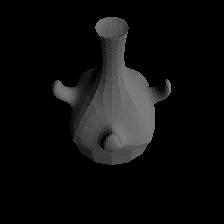

In [11]:
mesh = Mesh('./vase.obj')
image = render_single_view(mesh, elev = np.pi / 3)

Image.fromarray((image.squeeze(0).cpu().numpy() * 255.).astype('uint8'))

In [22]:
# To Render multiple images/views and combine to form a video
import cv2
import os

# Loop over different azimuth values to get multiple views
# Azimuth Range 0-360 degrees or 0-2pi radians
azimuths = np.linspace(0, 2 * np.pi, num=100)
print(azimuths)

# Now loop over them
frames = []
for azim in azimuths:
  frame = render_single_view(mesh, elev = np.pi / 3, azim = np.float(azim))
  frame = Image.fromarray((frame.squeeze(0).cpu().numpy() * 255.).astype('uint8'))
  frame = np.array(frame) 
  # Convert RGB to BGR 
  frame = frame[:, :, ::-1].copy() 
  frames.append(frame)

# Now convert frames array to video using openCV
height, width, layers = frames[0].shape

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter("vase.mp4", fourcc, 30, (width, height))

for frame in frames:
    video.write(frame)

video.release()



[0.         0.06346652 0.12693304 0.19039955 0.25386607 0.31733259
 0.38079911 0.44426563 0.50773215 0.57119866 0.63466518 0.6981317
 0.76159822 0.82506474 0.88853126 0.95199777 1.01546429 1.07893081
 1.14239733 1.20586385 1.26933037 1.33279688 1.3962634  1.45972992
 1.52319644 1.58666296 1.65012947 1.71359599 1.77706251 1.84052903
 1.90399555 1.96746207 2.03092858 2.0943951  2.15786162 2.22132814
 2.28479466 2.34826118 2.41172769 2.47519421 2.53866073 2.60212725
 2.66559377 2.72906028 2.7925268  2.85599332 2.91945984 2.98292636
 3.04639288 3.10985939 3.17332591 3.23679243 3.30025895 3.36372547
 3.42719199 3.4906585  3.55412502 3.61759154 3.68105806 3.74452458
 3.8079911  3.87145761 3.93492413 3.99839065 4.06185717 4.12532369
 4.1887902  4.25225672 4.31572324 4.37918976 4.44265628 4.5061228
 4.56958931 4.63305583 4.69652235 4.75998887 4.82345539 4.88692191
 4.95038842 5.01385494 5.07732146 5.14078798 5.2042545  5.26772102
 5.33118753 5.39465405 5.45812057 5.52158709 5.58505361 5.648520

<ipython-input-22-e4a9c86cf81f>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  frame = render_single_view(mesh, elev = np.pi / 3, azim = np.float(azim))
